[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/064_vit/vit.ipynb)

# *Visual Transformers*

En posts anteriores hemos aprendido e implementado la arquitectura *Transformer*, en particular el *Transformer Encoder*, usado en multitud de aplicaciones. Una de ellas, es la tarea de clasificación de imágenes. Y un ejemplo de implementación lo encontramos en el artículo [ViT](https://arxiv.org/abs/2010.11929).

![](vit.png)

Como puedes ver la arquitectura es muy similar a la implementada en el post anterior (no es casualidad). Ahora vamos a ver como implementar esta arquitectura en particular, la cual está dando mejores resultados que los modelos basados en redes convolucionales, las líderes indiscutibles en el campo de la visión artificial hasta día de hoy.

## Dataset

Una diferencia importante con respecto a nuestra implementación anterior es que, en vez de preparar las imágenes en patches, aplicaremos el *tiling* y la reproyección directamente usando una capa convolucional. Así pues, a nivel de dataset, simplemente tenemos que devolver nuestras imágenes y etiquetas como siempre.

In [1]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [2]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float().view(1, 28, 28), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
        self.train_ds = Dataset(X_train, y_train)
        self.val_ds = Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [3]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

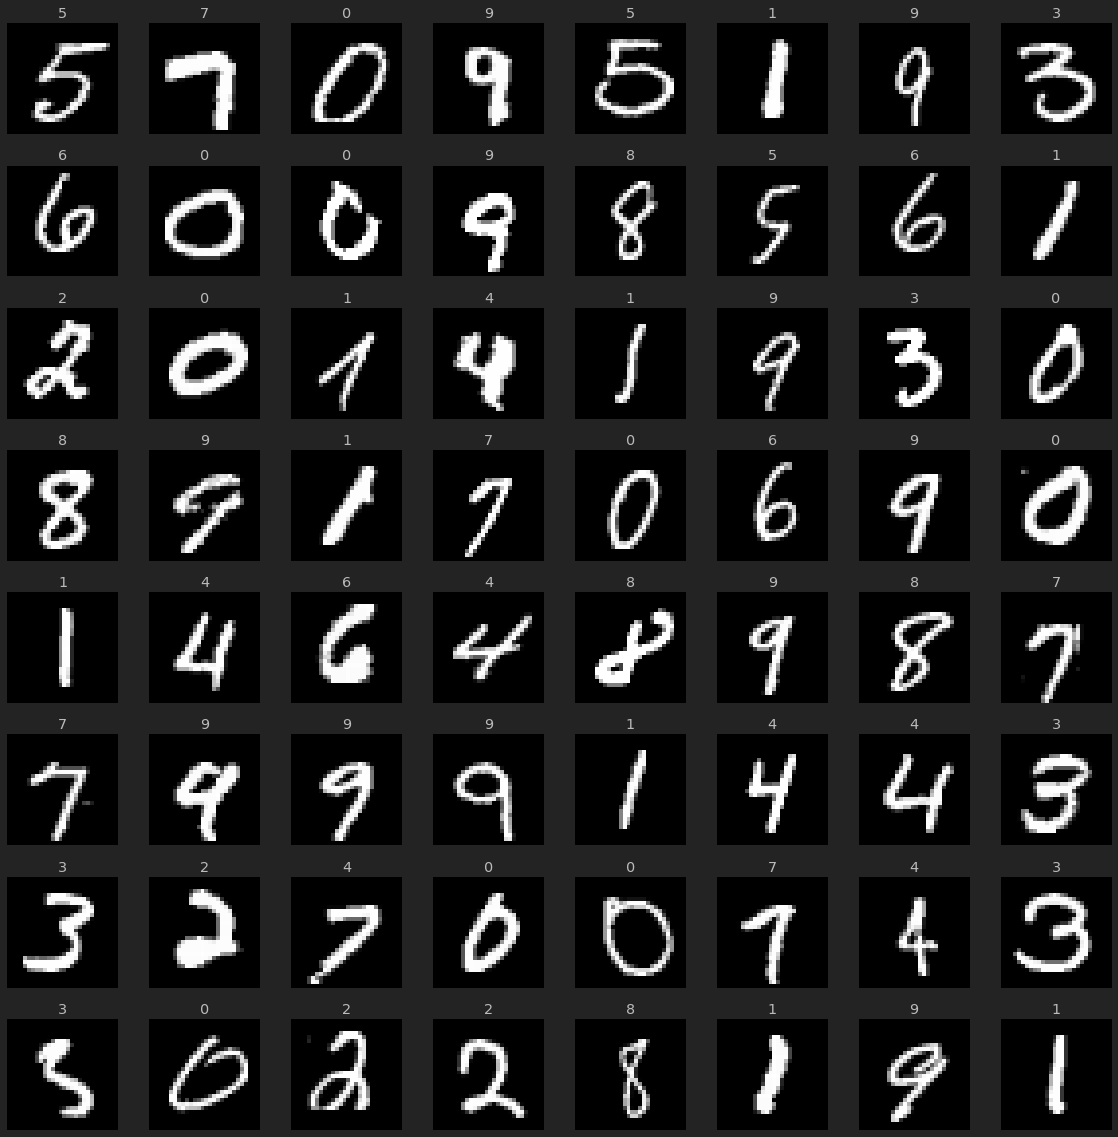

In [4]:
r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

## El modelo

Empezamos con la implementación del *patch embedding*. Este módulo recibirá un batch de imágenes y se encargará de proyectar los diferentes *patches*. Para ello podemos usar una capa convolucional con un tamaño de *kernel* y *stride* iguales al tamaño del *patch* que queramos usar.

In [5]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [6]:
pe = PatchEmbedding(28, 7, 1, 100)
out = pe(imgs)
out.shape

torch.Size([64, 16, 100])

Una vez tenemos nuestros datos proyectados, podemos dárselos a nuestro transformer encoder para que haga su magia.

In [7]:
import math

class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = nn.Linear(n_embd, n_embd*n_heads)
        self.query = nn.Linear(n_embd, n_embd*n_heads)
        self.value = nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

Siguiendo el trabajo de los autores originales, ya solo nos faltaría añadir el token `class` y los *postitional embeddings*. En implementaciones anteriores conectábamos la salida del transformer a un clasificador lineal para darnos el resultado final. En *ViT*, sin embargo, se utiliza un token especial al principio de la secuencia, al cual conectamos nuestro clasificador final.

In [9]:
class ViT(nn.Module):

    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=100, n_heads=3, n_layers=3, n_classes=10):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(embed_dim, n_heads) for _ in range(n_layers)])
        
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        e = self.patch_embed(x)
        B, L, E = e.size()
        
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        e = torch.cat((cls_token, e), dim=1)  # (B, 1 + N, E)
        e = e + self.pos_embed  # (B, 1 + N, E)
        
        z = self.tranformer(e)
        
        cls_token_final = z[:, 0]  
        y = self.fc(cls_token_final)

        return y

In [10]:
vit = ViT()
out = vit(imgs)
out.shape

torch.Size([64, 10])

In [11]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.vit = ViT()

    def forward(self, x):
        return self.vit(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [12]:
model = Model()
out = model(imgs)
out.shape

torch.Size([64, 10])

In [13]:
model = Model()
trainer = pl.Trainer(max_epochs=5, gpus=1)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vit  | ViT  | 613 K 
/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/sensio/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

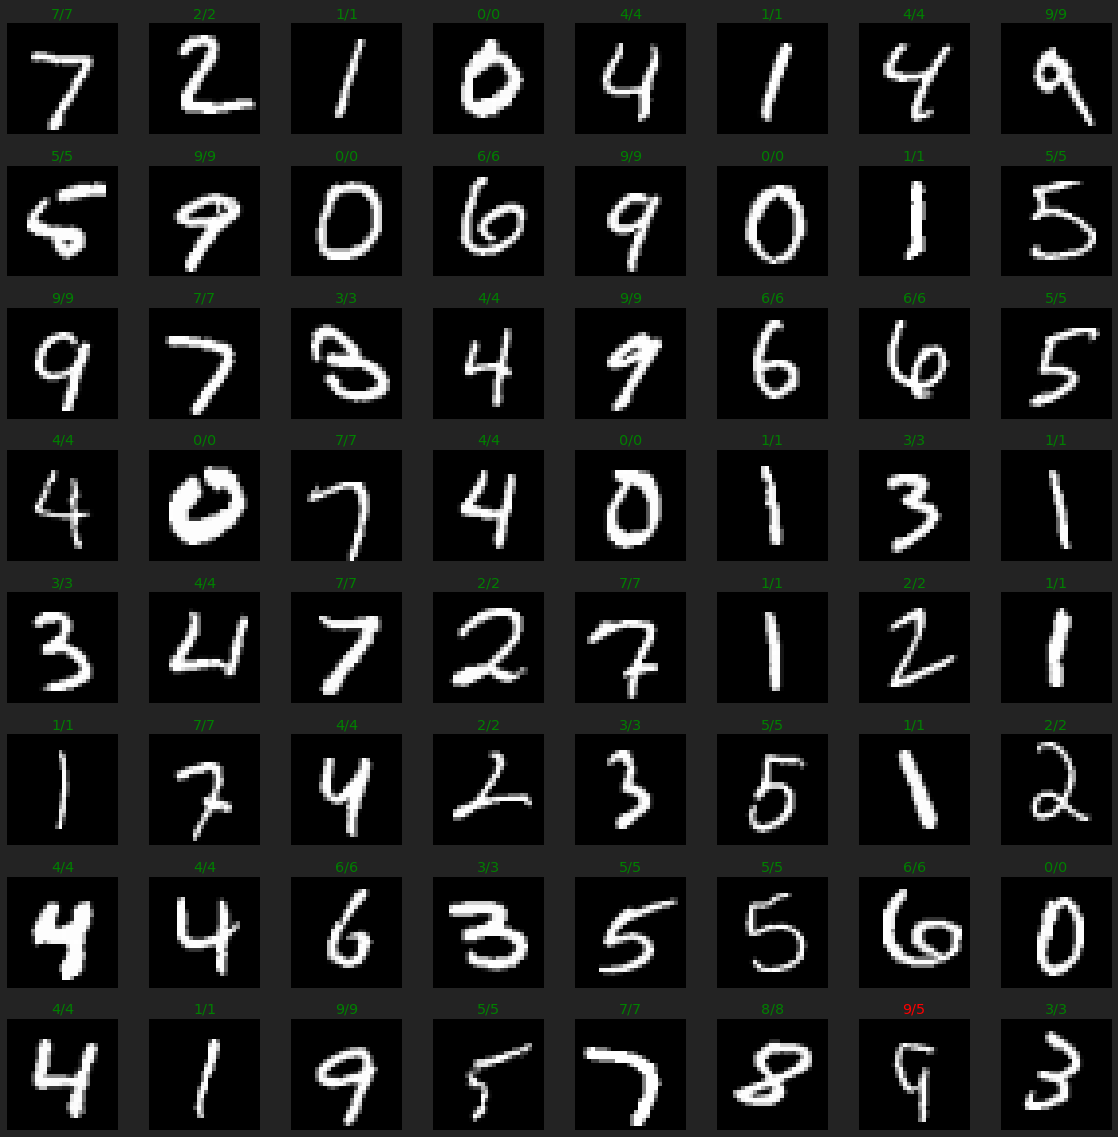

In [14]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Si bien nuestra implementación es funcional, podemos utilizar otras que ya existan para asegurarnos que todo está bien implementado y optimizado. Una solución recomendable es usar la librería [timm](https://github.com/rwightman/pytorch-image-models).

In [15]:
from timm.models.vision_transformer import VisionTransformer

# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

class Model2(Model):
    def __init__(self):
        super().__init__()
        self.vit = VisionTransformer(
            img_size=28, 
            patch_size=7, 
            in_chans=1, 
            num_classes=10, 
            embed_dim=100, 
            depth=3, 
            num_heads=2
        )

In [16]:
model2 = Model2()
out = model2(imgs)
out.shape

torch.Size([64, 10])

In [17]:
model2 = Model2()
trainer = pl.Trainer(max_epochs=5, gpus=1, precision=16)
trainer.fit(model2, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name | Type              | Params
-------------------------------------------
0 | vit  | VisionTransformer | 371 K 


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

En este caso la diferencia en número de parámetros y precisión se debe a que, en la implementació original del *Transformer*, el cálculo de las *keys*, *queries* y *values* se divide entre las diferentes cabezas, mientras que en nuestra implementación (debido a la baja dimensionalidad del problema) las estamos multiplicando. 

## Resumen

En este post hemos utilizado los diferentes conceptos vistos anteriormente para construir un modelo de clasificación de imágen *state of the art* basado en transformers, el modelos conocido como *ViT*. También hemos visto como, a la práctica, es mucho mejor utilizar una buena implementación de una librería externa.